<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Feature Selection</h3>
</div>

Chris Lomeli
Springboard Capstone




## <font color=#0e0654>This notebook is for demonstration of the feature selection process</font>

The goal for this notebook is to demonstrate the steps for feature selection for a team/week win/loss predictor.  Every team in every week of every season will have two rows, one for the home team and one for the away team.  Thier stats are different even hough they appear together in a single NFLVerse record.

All of these tasks would normally be autonomously run as part of the nfl_main_job.py source, but can be manually run from this notebook for demo purposes.

The first part of this effort is to split the data we have into offense and defense data - offense can have different features than defense, so we want to analyze them separately.  Once we have the best features for each we want to merge them back into the base play-action data

The steps to accomplish this are:

- Run the job to perform feature selection for offense features

- we use sklearn corr() to get correlation

- we use xgboost to get feature importance

- create the weighted averages of the best offense features into an offense 'power' score

- after all is done we'll go back and run some of the plots that hopefully explain the way we programmably chose our features,

Once we complete feature selection for offense, we'll do the same for defense.

<br>

<br>

## <font color=#0e0654>artifacts</font>

#### <font color=#0e0654>input</font>

- tmp_weekly_defense.parquet
- tmp_weekly_offense.parquet
- tmp_weekly_play_actions.parquet

#### <font color=#0e0654>temp files</font>

- tmp_defense_week_features.parquet
- tmp_offense_week_features.parquet

#### <font color=#0e0654>output</font>

- weekly_game_stats.parquet



<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">imports</h3>
</div>

In [3]:
import os
import sys
sys.path.append(os.path.abspath("../src"))


In [4]:
from src import *


In [5]:
logger = configs.configure_logging("pbp_logger")
logger.setLevel(logging.INFO)

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">offense features</h3>
</div>


### <font color="#0e0654">load and transform weekly offense stats</font>

<font color=#0e0654>

- load the weekly dataset
- train xgboost feature model
- choose best features
- calculate the weighted averages of features into a 'power' score
- mege this new data into the pay

</font>

In [6]:
from src.nfl_03_perform_feature_selection import SelectNFLFeatures

F = SelectNFLFeatures("offense")
F.get_best_features()
F.calculate_and_add_power_score()
F.input_stats_df.head()

2023-07-21 15:31:46,271 - INFO - SelectNFLFeatures
2023-07-21 15:31:46,271 - INFO - load tmp_weekly_offense
2023-07-21 15:31:46,347 - INFO - prepare a features dataset
2023-07-21 15:31:46,347 - INFO - encode the target win/loss column
2023-07-21 15:31:46,349 - INFO - create a features dataframe for feature selection ...
2023-07-21 15:31:46,349 - INFO - scale all features  ...
2023-07-21 15:31:47,033 - INFO - get percentage contribution of offensive and defensive features
2023-07-21 15:31:47,037 - INFO - calculate weighted average of offensive and defensive features


,team,season,week,passing_tds,passing_yards,passing_epa,ps_attempts,rushing_first_downs,ps_completions,receptions,...,team_score,team_coach,opposing_team,opposing_score,opposing_coach,spread,count,win,target,offense_power
index,,,,,,,,,,,,,,,,,,,,,
0,ARI,2016,1,2.0,271.0,0.829865,37.0,6.0,24.0,24.0,...,21,Bruce Arians,NE,23,Bill Belichick,-2.0,1,loss,0,32.865017
1,ARI,2016,2,3.0,315.0,1.126585,34.0,4.0,18.0,18.0,...,40,Bruce Arians,TB,7,Dirk Koetter,33.0,1,win,1,37.146040
2,ARI,2016,3,0.0,287.0,-1.008722,50.0,5.0,26.0,26.0,...,18,Bruce Arians,BUF,33,Rex Ryan,-15.0,1,loss,0,35.402201
3,ARI,2016,4,1.0,325.0,-0.389266,47.0,6.0,27.0,27.0,...,13,Bruce Arians,LA,17,Jeff Fisher,-4.0,1,loss,0,37.129989
4,ARI,2016,5,2.0,124.0,-0.544776,28.0,10.0,11.0,11.0,...,33,Bruce Arians,SF,21,Chip Kelly,12.0,1,win,1,30.686975


### <font color="#0e0654">review weekly offense features</font>


<br>

#### <font color=teal>A heatmap chart shows some correlations between and among offense features</font>

We'll isolate them with respect to out target win/loss column in the next chart

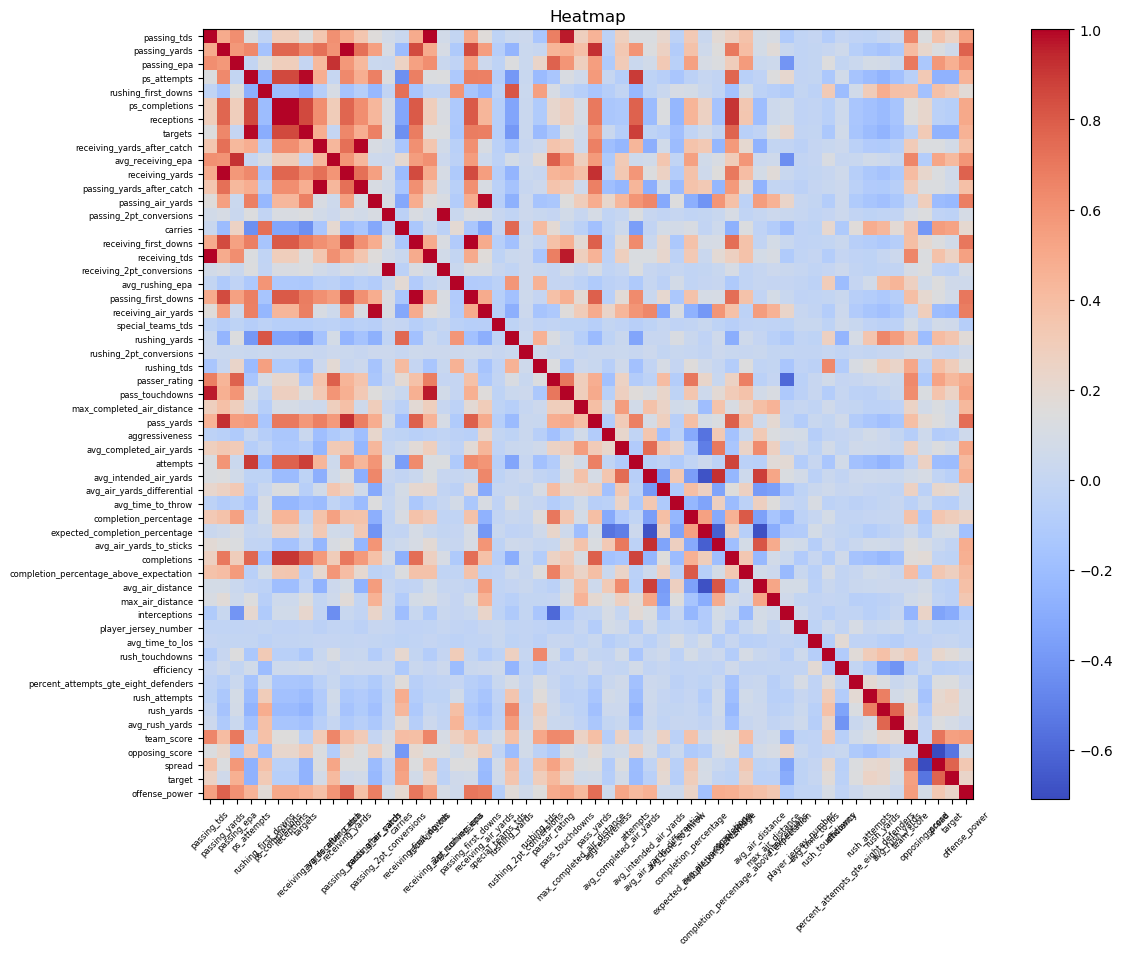

In [6]:
F.show_heatmap()


<br>

#### <font color=teal>Isolate just those correlations that have some correlation with  wins and losses</font>



/Users/christopherlomeli/Source/courses/datascience/Springboard/capstone/NFL/NFLVersReader/src/util/utils_eda.py:123: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


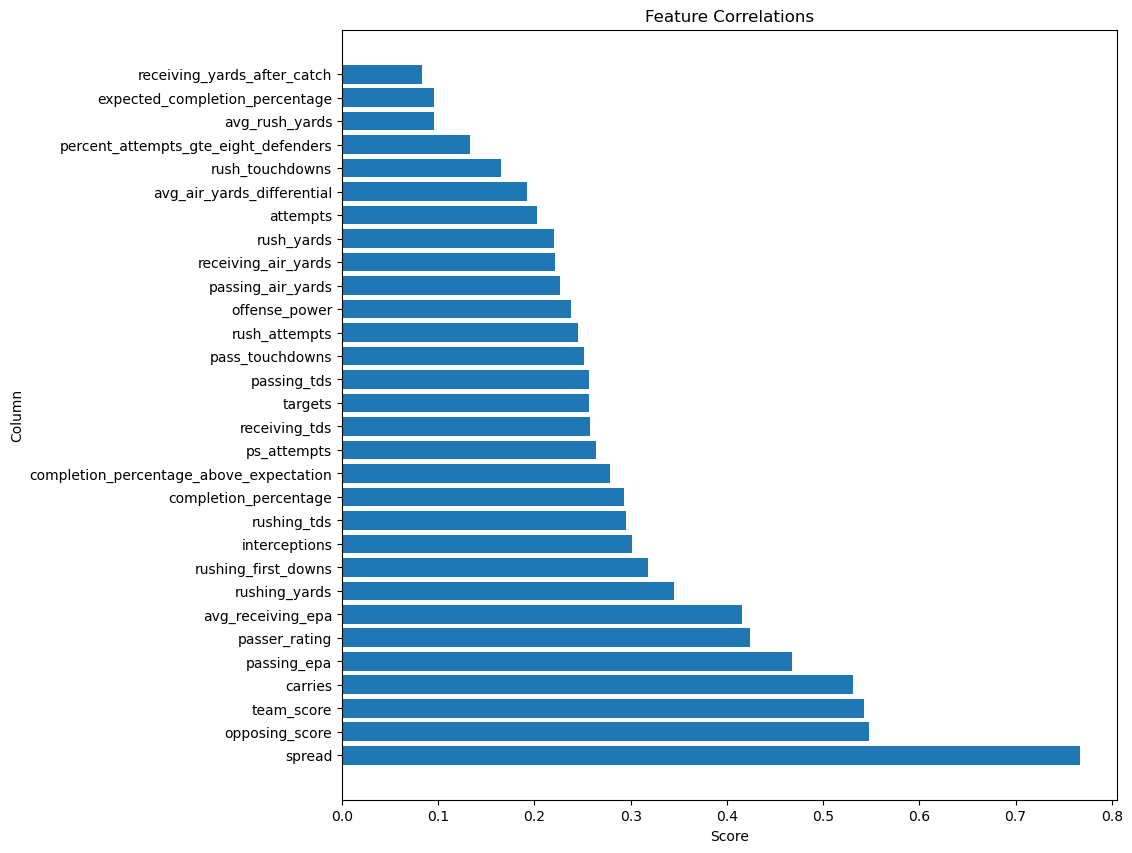

In [7]:
F.show_correlations()

#### <font color=teal>Run a feature model to get the most important features</font>

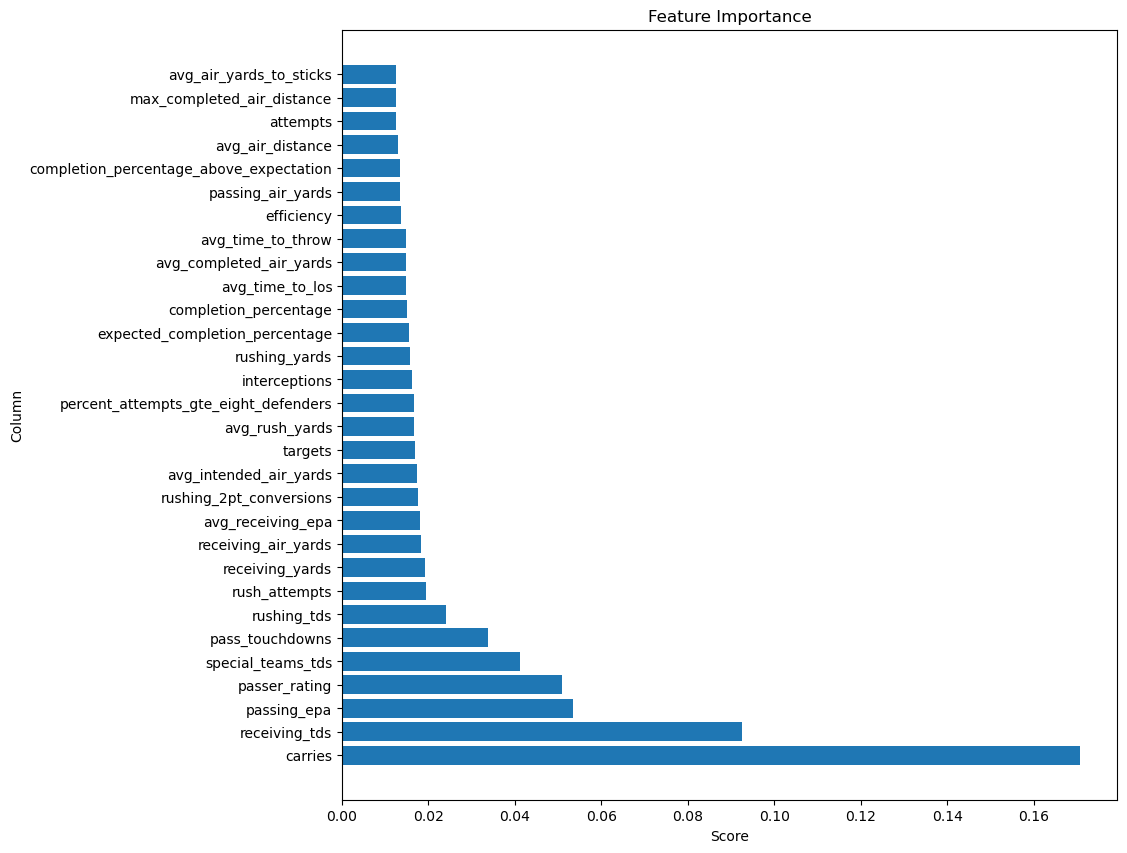

In [8]:
F.plot_best_features()

<br>

#### <font color=teal>We then use xgboost to calculate the best features and the level of importance to wins and losses</font>

- XGBoost will provide a percentage feature importance for all features,  We'll take the top features, and re-calculate the percentage of importance between just our top features.  These are our weights.

- We'll then use those weights and the original raw values to come up with a weighted average 'power' score for each team in each week orf each season.


---


<div style="background-color: #610909; padding: 10px;">
    <h3 style="color: white;">defense features</h3>
</div>


## <font color=#a81b11>review weekly defense features</font>


### <font color=#a81b11>load and transform weekly defense stats</font>
- load the weekly dataset
- train xgboost feature model
- choose best features
- calculate the weighted averages of features into a 'power' score

In [9]:
D = SelectNFLFeatures("defense")
D.get_best_features()
D.calculate_and_add_power_score()
D.input_stats_df.head()

2023-07-20 17:19:41,754 - INFO - SelectNFLFeatures
2023-07-20 17:19:41,755 - INFO - load tmp_weekly_defense
2023-07-20 17:19:41,759 - INFO - prepare a features dataset
2023-07-20 17:19:41,760 - INFO - encode the target win/loss column
2023-07-20 17:19:41,761 - INFO - create a features dataframe for feature selection ...
2023-07-20 17:19:41,761 - INFO - scale all features  ...
2023-07-20 17:19:42,446 - INFO - get percentage contribution of offensive and defensive features
2023-07-20 17:19:42,448 - INFO - calculate weighted average of offensive and defensive features


,team,season,week,rushing_fumbles_lost,sack_fumbles,sack_fumbles_lost,rushing_first_downs,receiving_fumbles_lost,sack_yards,sacks,...,team_score,team_coach,opposing_team,opposing_score,opposing_coach,spread,count,win,target,defense_power
index,,,,,,,,,,,,,,,,,,,,,
0,ARI,2016,1,0.0,0.0,0.0,6.0,0.0,19.0,3.0,...,21,Bruce Arians,NE,23,Bill Belichick,-2.0,1,loss,0,6.096541
1,ARI,2016,2,0.0,0.0,0.0,4.0,0.0,4.0,1.0,...,40,Bruce Arians,TB,7,Dirk Koetter,33.0,1,win,1,5.389760
2,ARI,2016,3,1.0,2.0,0.0,5.0,0.0,27.0,5.0,...,18,Bruce Arians,BUF,33,Rex Ryan,-15.0,1,loss,0,8.135260
3,ARI,2016,4,1.0,1.0,1.0,6.0,0.0,23.0,3.0,...,13,Bruce Arians,LA,17,Jeff Fisher,-4.0,1,loss,0,5.950556
4,ARI,2016,5,0.0,0.0,0.0,10.0,0.0,8.0,1.0,...,33,Bruce Arians,SF,21,Chip Kelly,12.0,1,win,1,7.458377


<br>

#### <font color=#a81b11>A heatmap chart shows somewhat weak correlations between and among defense features</font>

We'll isolate them with respect to out target win/loss column in the next chart

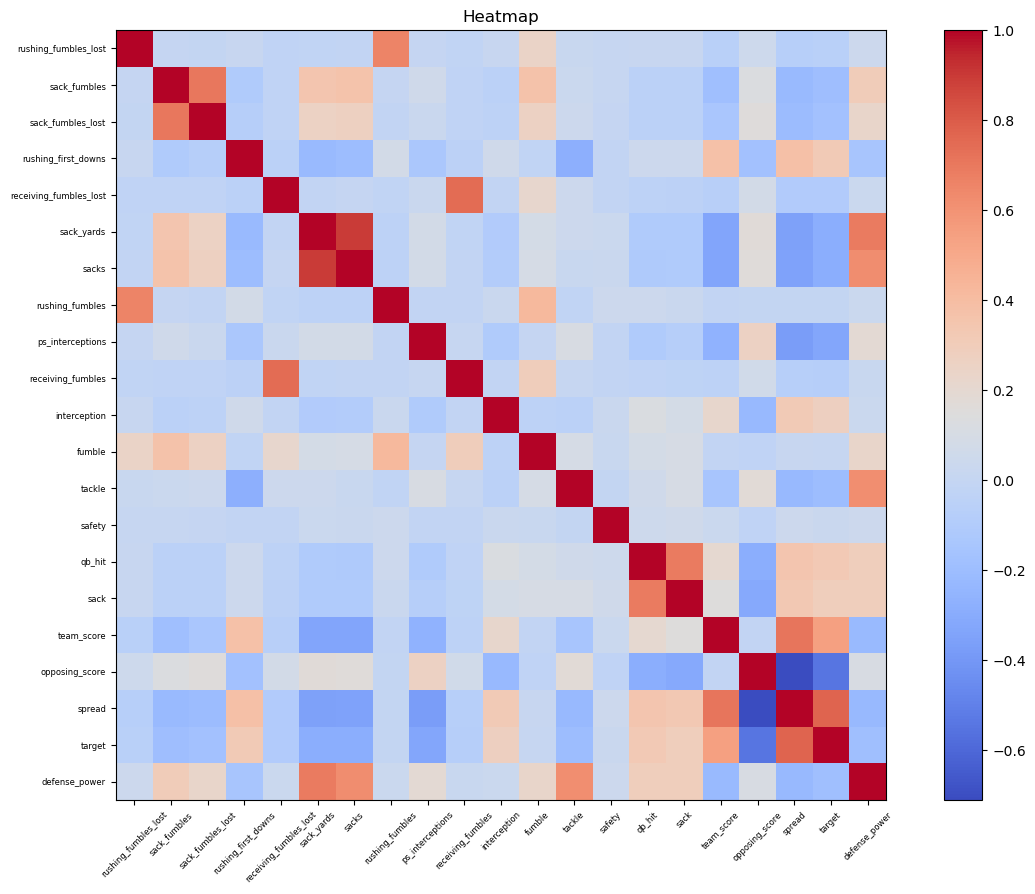

In [10]:
D.show_heatmap()

<br>

#### <font color=#a81b11>Here we use sklearn to isolate just those correlations that have some correlation with  wins and losses</font>


/Users/christopherlomeli/Source/courses/datascience/Springboard/capstone/NFL/NFLVersReader/src/util/utils_eda.py:123: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


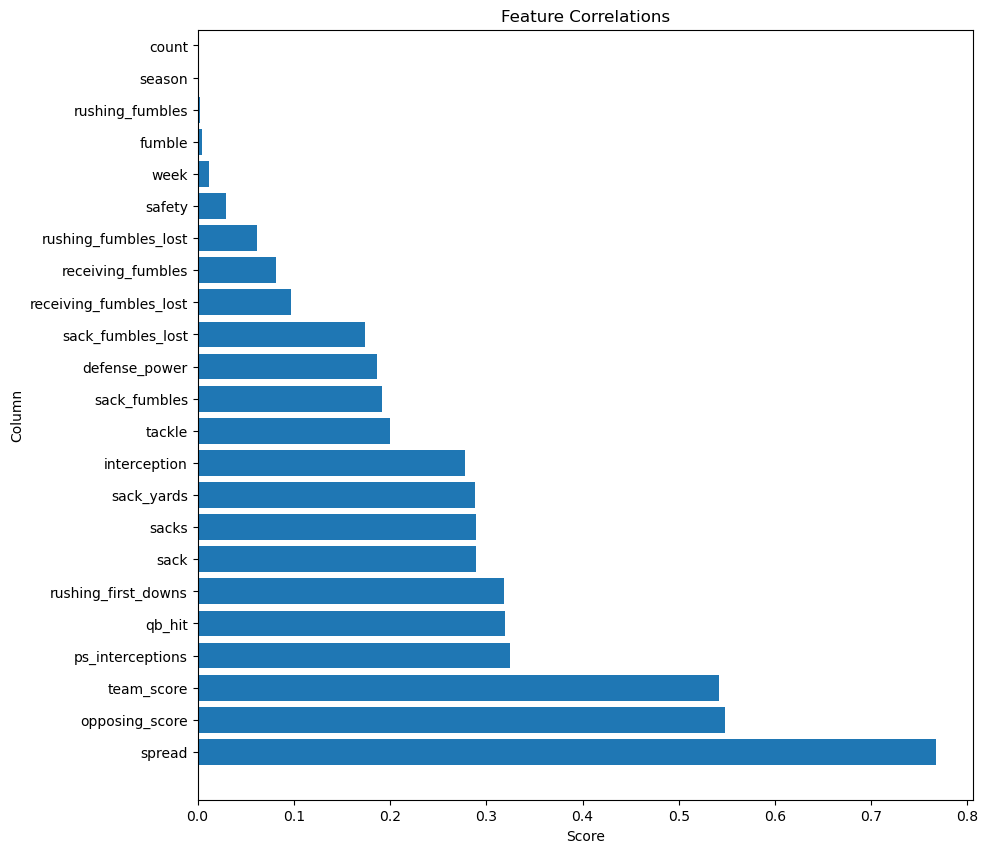

In [11]:
D.show_correlations()

<br>

#### <font color=#a81b11>And as with offense we use xgboost to get the most important features</font>


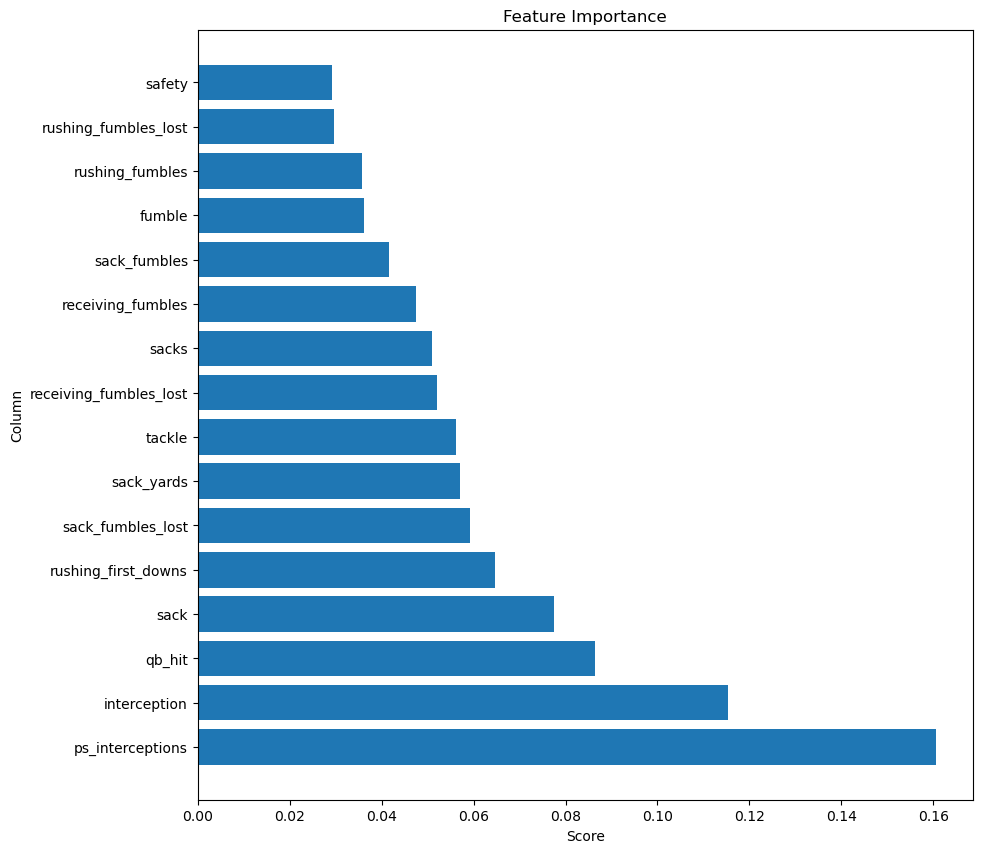

In [12]:
D.plot_best_features()

<div style="background-color: #041d5c; padding: 10px;">
    <h3 style="color: white;">merge into weekly game stats</h3>
</div>


we now save the offense and defense features, then merge the offense and defense data into the play action dataset to create the weekly game stat

<br>

#### <font color=#041d5c>Save the offense and defense data</font>

The actual merging step is a different job, so we store the offense and defense features first,
The autonomous merge process will pick them up and perform the next job (below)


In [13]:
F.write_output()
D.write_output()

2023-07-20 17:19:42,869 - INFO - Writing to tmp_offense_week_features
2023-07-20 17:19:42,971 - INFO - Writing to tmp_defense_week_features


<br>

#### <font color=#041d5c>merge offense and defense scores into the play action dataset </font>

This job reads the defense and offense features back in, then merges them into the play action dataset to create the weekly_game_stats dtaset that we'll use in our e-week win/loss experiment

In [14]:
from src.nfl_04_merge_game_features import merge_team_week_features

merge_team_week_features()

2023-07-20 17:19:42,991 - INFO - loading weekly features into a single game dataset...
2023-07-20 17:19:42,991 - INFO - Reading from tmp_weekly_play_actions
2023-07-20 17:19:43,111 - INFO - Reading from tmp_offense_week_features
2023-07-20 17:19:43,115 - INFO - Reading from tmp_defense_week_features
2023-07-20 17:19:43,118 - INFO - merge stats into play_actions...
2023-07-20 17:19:43,966 - INFO - merging offense_OP...
2023-07-20 17:19:44,901 - INFO - merging offense_DP...
2023-07-20 17:19:46,003 - INFO - merging defense_OP...
2023-07-20 17:19:46,684 - INFO - merging defense_DP...
2023-07-20 17:19:46,707 - INFO - aggregate game dataset weekly stats by season, week, team...
2023-07-20 17:19:46,960 - INFO - writing file weekly_game_stats
